In [16]:
import json
import pandas as pd
import numpy as np
import os
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# ==================== Load data ====================
file_path = "raw_results/complete_judge_result.jsonl"
if not os.path.exists(file_path):
    print(f"File {file_path} not found.")
    exit()

with open(file_path, "r", encoding="utf-8") as f:
    data = [json.loads(line.strip()) for line in f if line.strip()]

df = pd.DataFrame(data)
test_df = df[df['split'] == 'test'].reset_index(drop=True)

JUDGE_COLS = [
    'qwen',
    'llama',
    'mistral',
    'chatglm',
    'gemma'
]


methods = ["BGE@0.85", "LLM Average", "Majority Vote", "neural_model", "ral2m"]

In [17]:
# ==================== 2. Evaluation Function ====================
import json
import pandas as pd
import numpy as np
import os
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# ==================== 2. Evaluation Function ====================
def evaluate_judge(df_subset, method):
    if len(df_subset) == 0:
        return None

    # 1. Map 'method' to the correct boolean column
    if method == "BGE@0.85":
        accepted = df_subset['bge_retrieved_top1_score'] >= 0.85
    elif method == "Majority Vote":
        votes = df_subset[['qwen', 'llama', 'mistral', 'chatglm', 'gemma']].astype(int).sum(axis=1)
        accepted = votes >= 3
    else:
        accepted = df_subset[method.lower()]

    y_true = df_subset['y_true'].astype(bool)
    
    # 2. Confusion Matrix Components
    tp = (accepted & y_true).sum()
    tn = (~accepted & ~y_true).sum()
    fp = (accepted & ~y_true).sum()
    fn = (~accepted & y_true).sum()
    
    n_pos = y_true.sum()
    n_neg = (~y_true).sum()
    total = len(df_subset)

    # 3. Metric Calculations
    accuracy = (tp + tn) / total if total > 0 else 0
    recall = tp / n_pos if n_pos > 0 else 0
    neg_reject = tn / n_neg if n_neg > 0 else 0
    hallu_risk = fp / (fp + tn) if (fp + tn) > 0 else 0 # FAR
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # --- NEW METRIC: Accept Ratio ---
    # Total items the judge said 'Yes' to / Total items that ARE actually 'Yes'
    # Measures the judge's bias/tendency compared to ground truth volume
    accept_ratio = accepted.sum() / n_pos if n_pos > 0 else 0

    return {
        "Method": method,
        "Accept%": f"{accepted.mean():.1%}",
        "Accept Ratio": f"{accept_ratio:.2f}",
        "Accuracy": f"{accuracy:.4f}",
        "Hallu Risk%": f"{hallu_risk:.1%}",
        "Recall%": f"{recall:.1%}",
        "Neg Reject%": f"{neg_reject:.1%}",
        "F1": f"{f1:.4f}"
    }
    
# ==================== 3. Execution ====================
# This includes individual LLMs, your heuristic (BGE), and your ensemble (Majority)
methods = ["BGE@0.85", "qwen", "llama", "mistral", "gemma", "chatGLM", "Majority Vote"]

# ==================== 2. Run Evaluation for Test Set ====================
test_results = []

for m in methods:
    # Run the evaluation function we defined previously
    metrics = evaluate_judge(test_df, m)
    if metrics:
        test_results.append(metrics)

# ==================== 3. Format and Print the Table ====================
# Convert list of dicts to a DataFrame for pretty printing
results_df = pd.DataFrame(test_results)

# Reorder columns to ensure the most important metrics are front and center
column_order = ["Method", "Accept%", "Accuracy", "Hallu Risk%", "Recall%", "Neg Reject%", "F1"]
results_df = results_df[column_order]

print("\n" + "="*105)
print(f"{'FINAL TEST SET EVALUATION RESULTS':^105}")
print("="*105)
# to_string(index=False) removes the row numbers for a cleaner look
print(results_df.to_string(index=False))
print("="*105)

# Optional: Add a brief legend to the printout
print("Metric Definitions:")
print(" - Hallu Risk%: False Acceptance Rate (FP / [FP + TN]) - Chance of missing a hallucination.")
print(" - Neg Reject%: Specificity (TN / [FP + TN]) - Success rate in blocking hallucinations.")
print("="*105 + "\n")


                                    FINAL TEST SET EVALUATION RESULTS                                    
       Method Accept% Accuracy Hallu Risk% Recall% Neg Reject%     F1
     BGE@0.85   41.5%   0.5132       41.4%   41.6%       58.6% 0.4230
         qwen   16.6%   0.6587        6.9%   29.5%       93.1% 0.4260
        llama   25.8%   0.6155       18.7%   35.2%       81.3% 0.4397
      mistral   99.7%   0.4285       99.7%   99.6%        0.3% 0.5991
        gemma   49.5%   0.5858       42.0%   59.4%       58.0% 0.5516
      chatGLM   89.8%   0.4886       85.8%   95.1%       14.2% 0.6146
Majority Vote   59.3%   0.6023       49.2%   72.8%       50.8% 0.6109
Metric Definitions:
 - Hallu Risk%: False Acceptance Rate (FP / [FP + TN]) - Chance of missing a hallucination.
 - Neg Reject%: Specificity (TN / [FP + TN]) - Success rate in blocking hallucinations.



In [18]:
# Assuming test_df['y_true'] has been defined as (test_df['retrieved_id'] == test_df['question_id'])
counts = test_df['y_true'].value_counts()

print("Value Counts for y_true:")
print(counts)

# To see the proportions/percentages:
proportions = test_df['y_true'].value_counts(normalize=True)
print("\nProportions:")
print(proportions)

Value Counts for y_true:
y_true
0    14303
1    10736
Name: count, dtype: int64

Proportions:
y_true
0    0.571229
1    0.428771
Name: proportion, dtype: float64


In [19]:
def evaluate_judge(df_subset, method):
    if len(df_subset) == 0:
        return None
    
    y_true = df_subset['y_true'].astype(bool).values
    
    if method == "BGE@0.85":
        id_match = (df_subset['bge_retrieved_top1_id'] == df_subset['question_id'])
        accepted = id_match & (df_subset['bge_retrieved_top1_score'] >= 0.85).values
    elif method == "Majority Vote":
        votes = df_subset[JUDGE_COLS].fillna(0).astype(int).sum(axis=1)
        accepted = (votes >= 3).values
    elif method == "LLM Average":
        # Pooled: treat each LLM vote as independent observation
        accepted = df_subset[JUDGE_COLS].fillna(0).astype(bool).values.flatten()
        y_true = np.repeat(y_true, len(JUDGE_COLS))
    elif method == "RAL2M":
        accepted = df_subset['ral2m'].astype(bool).values
    elif method == "Neural Model":
        accepted = df_subset['neural_model'].astype(bool).values
    else:
        accepted = df_subset[method].astype(bool).values
    
    tn, fp, fn, tp = confusion_matrix(y_true, accepted, labels=[False, True]).ravel()
    
    total = len(y_true)
    n_pos = tp + fn
    n_neg = tn + fp
    
    accuracy = (tp + tn) / total
    recall = tp / n_pos if n_pos > 0 else 0.0
    specificity = tn / n_neg if n_neg > 0 else 0.0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    hallu_risk = fp / (fp + tn)
    
    return {
        "Method": method,
        "Accuracy": accuracy,
        "Hallu Risk": hallu_risk,
        "Recall%": recall,
        "Neg Reject%": specificity,
        "Precision": precision,
        "F1": f1
    }

In [20]:
# ==================== Performance Evaluation (Metrics) ====================
methods = ["BGE@0.85", "LLM Average", "Majority Vote", "Neural Model", "RAL2M"]

results = [evaluate_judge(test_df, m) for m in methods if evaluate_judge(test_df, m)]

final_df = pd.DataFrame(results)
# final_df = final_df[["Method", "Accept%", "Accuracy", "Hallu Risk", "Recall%", "Neg Reject%", "Precision", "F1"]]
final_df = final_df[["Method", "Accuracy", "Hallu Risk", "Neg Reject%", "Precision", "F1"]]

# Formatting
display_df = final_df.copy()
display_df["Accuracy"] = display_df["Accuracy"].map("{:.1%}".format)
display_df["Hallu Risk"] = display_df["Hallu Risk"].map("{:.1%}".format)
# display_df["Recall%"] = display_df["Recall%"].map("{:.1%}".format)
display_df["Neg Reject%"] = display_df["Neg Reject%"].map("{:.1%}".format)
display_df["Precision"] = display_df["Precision"].map("{:.4f}".format)
display_df["F1"] = display_df["F1"].map("{:.4f}".format)

print("\n" + "="*100)
print(f"{'LLM JUDGE EVALUATION (TEST SET)':^100}")
print("="*100)
print(display_df.to_string(index=False))
print("="*100)
print("Recall%       : Sensitivity (TPR)")
print("Neg Reject%   : Specificity (TNR)")
print("Hallu Risk%   : False Discovery Rate")


                                  LLM JUDGE EVALUATION (TEST SET)                                   
       Method Accuracy Hallu Risk Neg Reject% Precision     F1
     BGE@0.85    53.1%      38.3%       61.7%    0.4492 0.4321
  LLM Average    55.5%      50.6%       49.4%    0.4860 0.5516
Majority Vote    60.2%      49.2%       50.8%    0.5262 0.6109
 Neural Model    64.2%      32.5%       67.5%    0.5797 0.5884
        RAL2M    70.7%      13.9%       86.1%    0.7299 0.5950
Recall%       : Sensitivity (TPR)
Neg Reject%   : Specificity (TNR)
Hallu Risk%   : False Discovery Rate


In [21]:
# ==================== Per-Dataset Performance Evaluation ====================
dataset_col = 'dataset'

if dataset_col not in test_df.columns:
    print(f"No '{dataset_col}' column. Available: {list(test_df.columns)}")
    exit()

datasets = sorted(test_df[dataset_col].unique())

# Per-dataset
print("\nPer-Dataset Performance (Test Set)")
print(f"{'Dataset':<20} {'Method':<15} {'Accuracy':<10} {'Hallu Risk%':<12}")
print("-" * 60)
for ds in datasets:
    sub_df = test_df[test_df[dataset_col] == ds]
    for m in methods:
        metrics = evaluate_judge(sub_df, m)
        if metrics:
            print(f"{ds:<20} {m:<15} {metrics['Accuracy']:.4f}     {metrics['Hallu Risk']:.1%}")

# Overall totals
print("\n" + "-" * 60)
print(f"{'OVERALL':<20} {'Method':<15} {'Accuracy':<10} {'Hallu Risk%':<12}")
print("-" * 60)
for m in methods:
    metrics = evaluate_judge(test_df, m)
    if metrics:
        print(f"{'TOTAL':<20} {m:<15} {metrics['Accuracy']:.4f}     {metrics['Hallu Risk']:.1%}")


Per-Dataset Performance (Test Set)
Dataset              Method          Accuracy   Hallu Risk% 
------------------------------------------------------------
covidqa              BGE@0.85        0.5722     28.0%
covidqa              LLM Average     0.5531     48.8%
covidqa              Majority Vote   0.6263     40.1%
covidqa              Neural Model    0.6416     27.4%
covidqa              RAL2M           0.6645     13.2%
expertqa             BGE@0.85        0.5795     25.9%
expertqa             LLM Average     0.5628     51.3%
expertqa             Majority Vote   0.6089     48.5%
expertqa             Neural Model    0.6822     21.4%
expertqa             RAL2M           0.7025     14.9%
hagrid               BGE@0.85        0.5602     34.0%
hagrid               LLM Average     0.5560     51.0%
hagrid               Majority Vote   0.5795     52.7%
hagrid               Neural Model    0.6559     32.4%
hagrid               RAL2M           0.7101     12.8%
hotpotqa             BGE@0.85   

In [22]:
# ==================== Performance Gain Evaluation ====================

datasets = sorted(test_df[dataset_col].unique()) + ["TOTAL"]

gain_rows = []
for ds_name in datasets:
    if ds_name == "TOTAL":
        sub_df = test_df
    else:
        sub_df = test_df[test_df[dataset_col] == ds_name]
    
    metrics = {m: evaluate_judge(sub_df, m) for m in methods}
    
    r_acc = metrics["RAL2M"]["Accuracy"]
    r_hallu = metrics["RAL2M"]["Hallu Risk"]
    
    for baseline in methods[:-1]:
        b_acc = metrics[baseline]["Accuracy"]
        b_hallu = metrics[baseline]["Hallu Risk"]
        
        gain_rows.append({
            "Dataset": ds_name,
            "Baseline": baseline,
            "Acc Gain (+)": r_acc - b_acc,
            "Hallu Reduc (+)": b_hallu - r_hallu
        })

gain_df = pd.DataFrame(gain_rows)

# Display
display_gain = gain_df.copy()
display_gain["Acc Gain (+)"] = display_gain["Acc Gain (+)"].map("{:+.4f}".format)
display_gain["Hallu Reduc (+)"] = display_gain["Hallu Reduc (+)"].map("{:+.1%}".format)

print("\nGain: RAL2M vs Baselines (Positive = RAL2M better)")
print(display_gain.sort_values(["Dataset", "Baseline"]).to_string(index=False))

# Average per baseline (excluding TOTAL)
avg_gain = gain_df[gain_df["Dataset"] != "TOTAL"].groupby("Baseline")[["Acc Gain (+)", "Hallu Reduc (+)"]].mean()
print("\nAverage Gain per Baseline (across datasets):")
print(avg_gain.round({"Acc Gain (+)": 4, "Hallu Reduc (+)": 4}))


Gain: RAL2M vs Baselines (Positive = RAL2M better)
 Dataset      Baseline Acc Gain (+) Hallu Reduc (+)
   TOTAL      BGE@0.85      +0.1760          +24.4%
   TOTAL   LLM Average      +0.1514          +36.7%
   TOTAL Majority Vote      +0.1045          +35.3%
   TOTAL  Neural Model      +0.0652          +18.6%
 covidqa      BGE@0.85      +0.0923          +14.8%
 covidqa   LLM Average      +0.1113          +35.6%
 covidqa Majority Vote      +0.0381          +26.9%
 covidqa  Neural Model      +0.0229          +14.2%
expertqa      BGE@0.85      +0.1230          +11.0%
expertqa   LLM Average      +0.1398          +36.3%
expertqa Majority Vote      +0.0936          +33.6%
expertqa  Neural Model      +0.0203           +6.5%
  hagrid      BGE@0.85      +0.1499          +21.2%
  hagrid   LLM Average      +0.1541          +38.2%
  hagrid Majority Vote      +0.1306          +39.9%
  hagrid  Neural Model      +0.0542          +19.6%
hotpotqa      BGE@0.85      +0.2921          +43.6%
hotpotqa   L

In [23]:
rows = []
for ds in datasets:
    sub_df = test_df[test_df[dataset_col] == ds]
    if len(sub_df) == 0:
        continue
    for m in methods:
        metrics = evaluate_judge(sub_df, m)
        if metrics:
            rows.append({
                "Dataset": ds,
                "Method": m,
                "Accuracy": metrics["Accuracy"],
                "Hallu Risk": metrics["Hallu Risk"]
            })

combined_df = pd.DataFrame(rows)

# Nicer formatting for display
combined_df["Accuracy"] = combined_df["Accuracy"].map("{:.4f}".format)
combined_df["Hallu Risk"] = combined_df["Hallu Risk"].map("{:.1%}".format)

# Build wide-format table
wide_rows = []
for ds in combined_df["Dataset"].unique():
    row = {"Dataset": ds}
    sub = combined_df[combined_df["Dataset"] == ds]
    for _, r in sub.iterrows():
        m = r["Method"]
        row[f"{m} Acc"] = r["Accuracy"]
        row[f"{m} Hallu↓"] = r["Hallu Risk"]
    wide_rows.append(row)

wide_df = pd.DataFrame(wide_rows)

/tmp/ipykernel_2491/1254894599.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


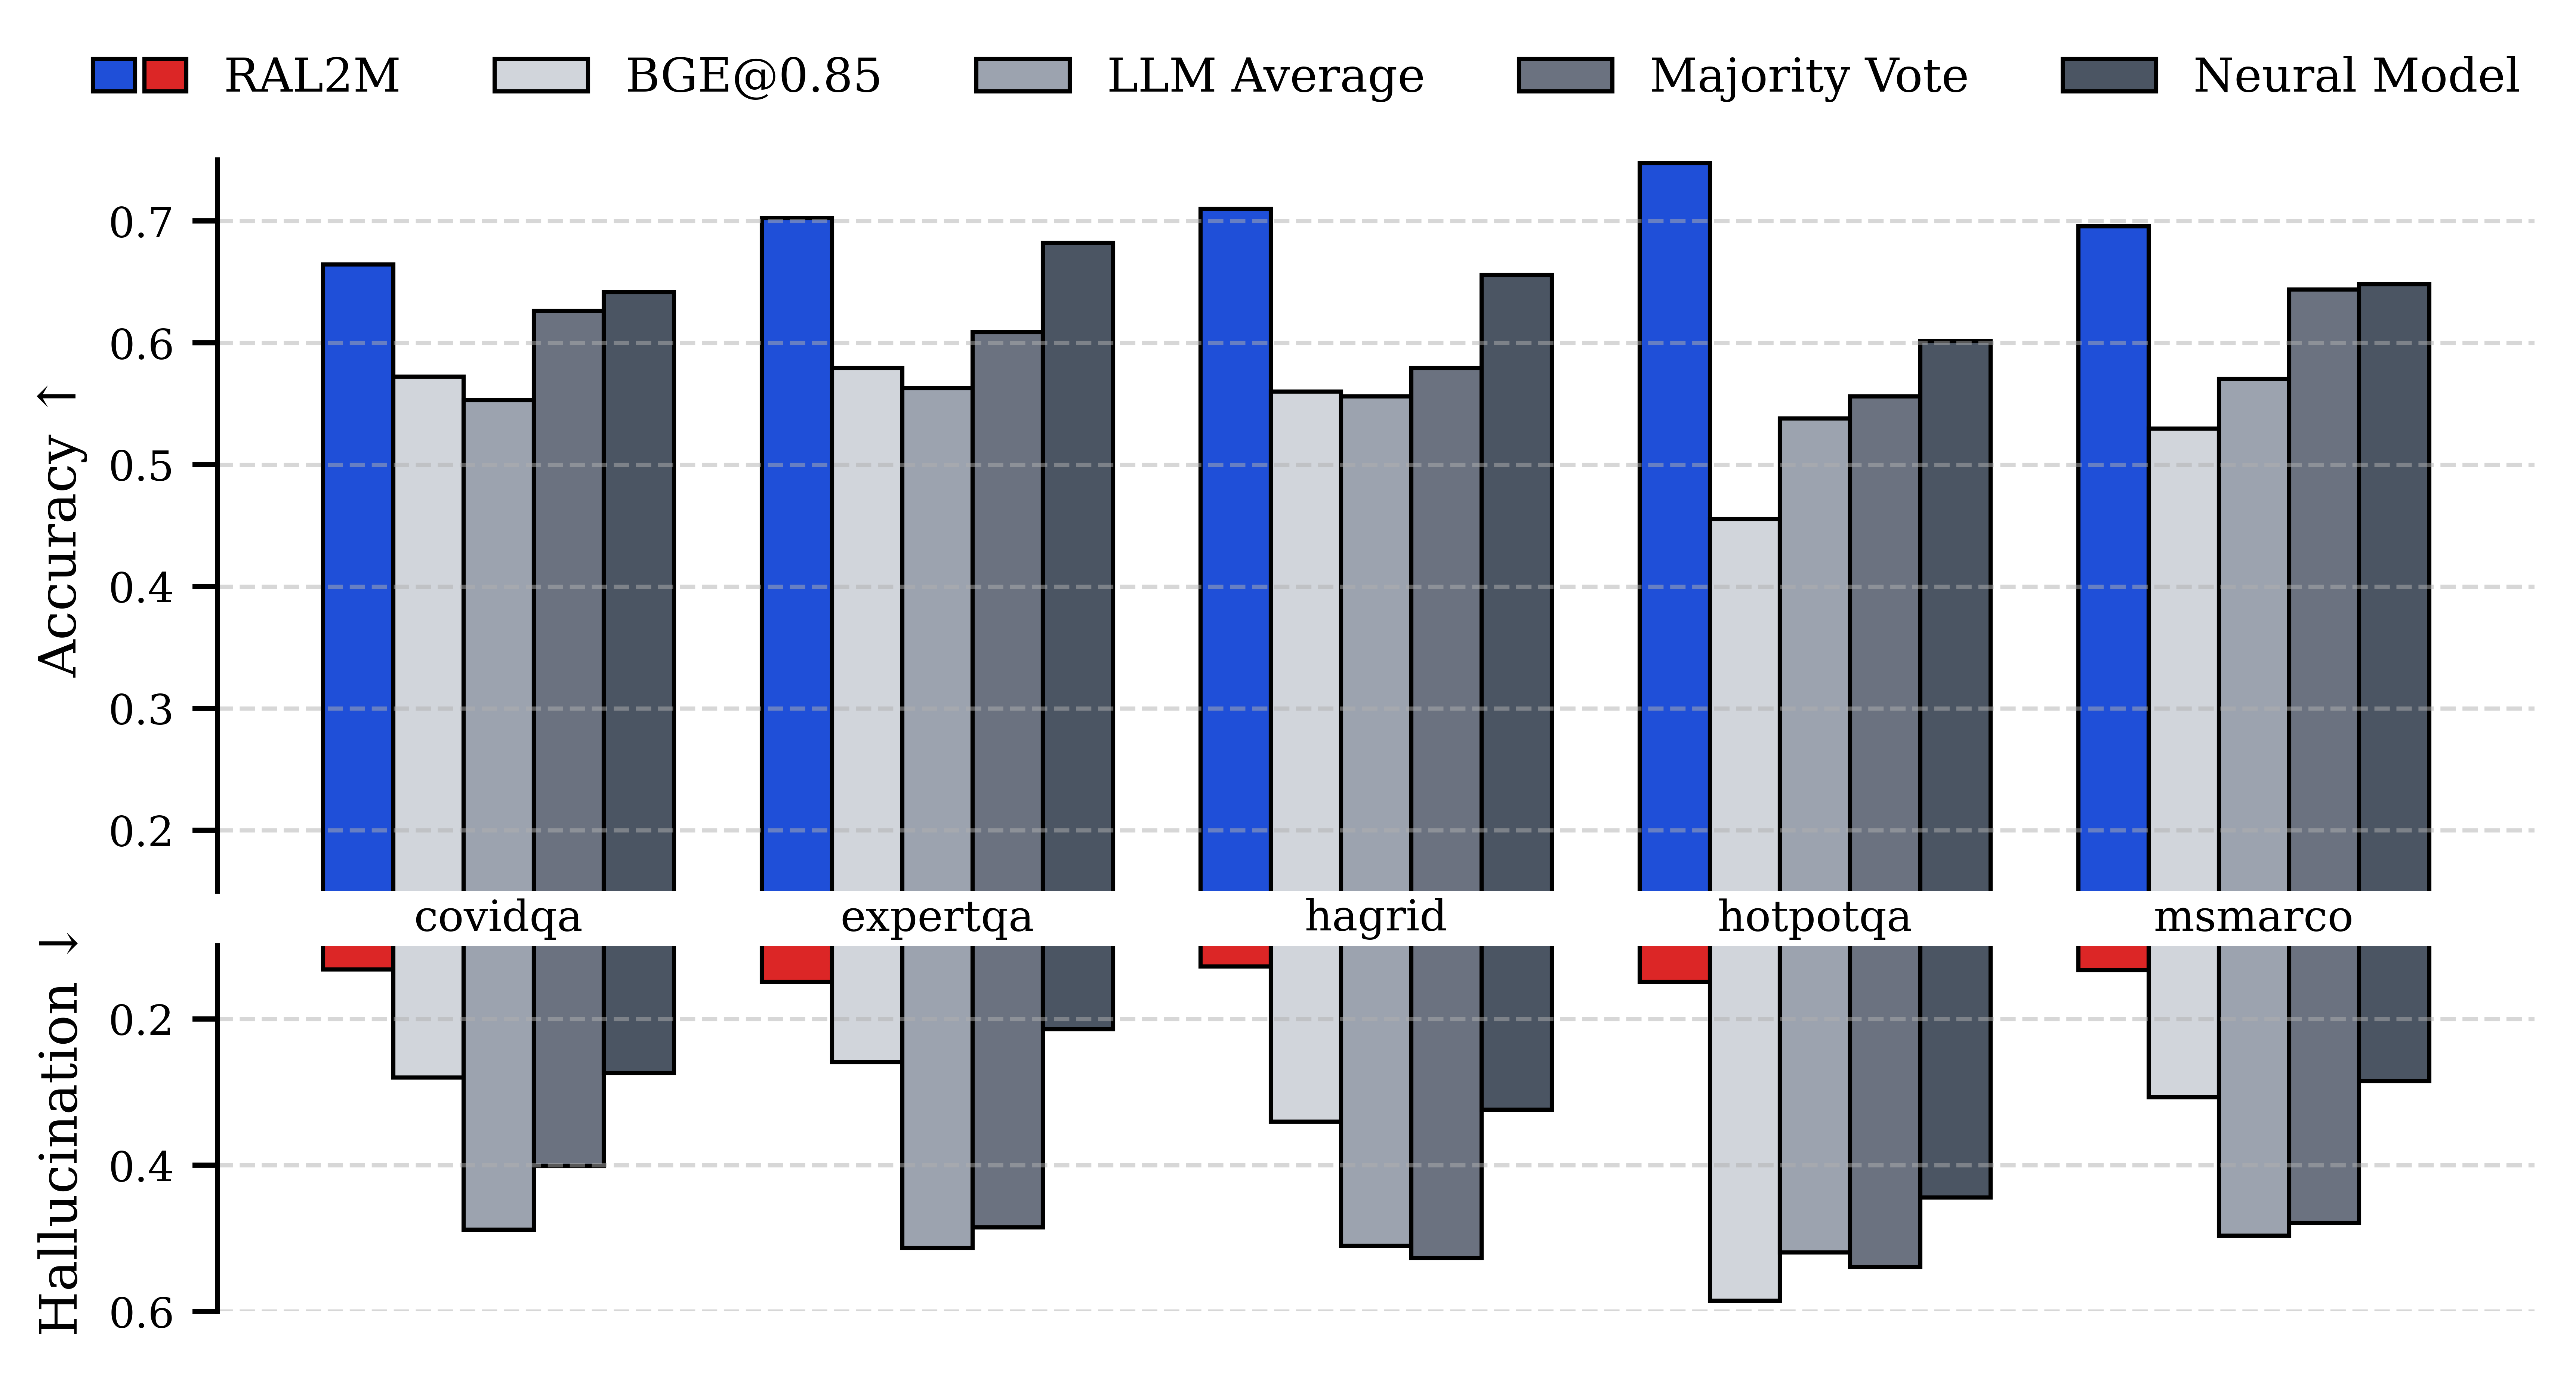

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.legend_handler import HandlerTuple


# ---------- Configuration ----------
os.makedirs("figures", exist_ok=True)
plt.rcParams['font.family'] = 'serif'
sns.set_context("paper", font_scale=1.3)

# Colors
method_colors_acc = {
    "RAL2M": "#1F4FD8", "BGE@0.85": "#D1D5DB", "LLM Average": "#9CA3AF",
    "Majority Vote": "#6B7280", "Neural Model": "#4B5563"
}
method_colors_hallu = {
    "RAL2M": "#DC2626", "BGE@0.85": "#D1D5DB", "LLM Average": "#9CA3AF",
    "Majority Vote": "#6B7280", "Neural Model": "#4B5563"
}

methods = ["RAL2M", "BGE@0.85", "LLM Average", "Majority Vote", "Neural Model"]
datasets = wide_df["Dataset"].tolist()
acc_data = {m: wide_df[f"{m} Acc"].astype(float).values for m in methods}
hallu_data = {m: wide_df[f"{m} Hallu↓"].str.rstrip('%').astype(float).values / 100 for m in methods}

# ---------- Plotting ----------
x = np.arange(len(datasets))
width = 0.16

# Create two subplots with no vertical space between them
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 9), sharex=True) # hspace creates the gap for text
# Use height_ratios to make ax2 shorter (Top is 2x the height of Bottom)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 4), sharex=True, 
                               gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.1}, dpi=1000)

# --- Top Plot: Accuracy ---
for i, m in enumerate(methods):
    offset = (i - (len(methods)-1)/2) * width
    ax1.bar(x + offset, acc_data[m], width=width, label=m,
            color=method_colors_acc[m], edgecolor='black', linewidth=0.8)

ax1.set_ylabel("Accuracy ↑", fontsize=10)
ax1.grid(axis='y', linestyle='--', alpha=0.5)
ax1.set_ylim(0.15, 0.75) # Adjust based on your data range
# ax1.legend(frameon=False, ncol=5, loc="upper center", bbox_to_anchor=(0.5, 1.18), fontsize=9)
# Set Y-tick fontsize for Accuracy plot
ax1.tick_params(axis='y', labelsize=8)

# --- Custom Half-Blue Half-Red Legend ---
# 1. Create Proxy patches
p_blue = plt.Rectangle((0, 0), 1, 1, facecolor=method_colors_acc["RAL2M"], edgecolor='black', linewidth=0.8)
p_red = plt.Rectangle((0, 0), 1, 1, facecolor=method_colors_hallu["RAL2M"], edgecolor='black', linewidth=0.8)
p_gray1 = plt.Rectangle((0, 0), 1, 1, facecolor=method_colors_acc["BGE@0.85"], edgecolor='black', linewidth=0.8)
p_gray2 = plt.Rectangle((0, 0), 1, 1, facecolor=method_colors_acc["LLM Average"], edgecolor='black', linewidth=0.8)
p_gray3 = plt.Rectangle((0, 0), 1, 1, facecolor=method_colors_acc["Majority Vote"], edgecolor='black', linewidth=0.8)
p_gray4 = plt.Rectangle((0, 0), 1, 1, facecolor=method_colors_acc["Neural Model"], edgecolor='black', linewidth=0.8)

# 2. Assemble handles (Combine blue and red for RAL2M)
handles = [
    (p_blue, p_red), # This will be the split icon
    p_gray1, p_gray2, p_gray3, p_gray4
]
labels = ["RAL2M", "BGE@0.85", "LLM Average", "Majority Vote", "Neural Model"]

ax1.legend(handles=handles, labels=labels, frameon=False, ncol=5, 
           loc="upper center", bbox_to_anchor=(0.47, 1.2), fontsize=9,
           handler_map={tuple: HandlerTuple(ndivide=None, pad=0.2)})


sns.despine(ax=ax1, bottom=True)

# --- Bottom Plot: Hallucination ---
for i, m in enumerate(methods):
    offset = (i - (len(methods)-1)/2) * width
    ax2.bar(x + offset, hallu_data[m], width=width,
            color=method_colors_hallu[m], edgecolor='black', linewidth=0.8)

ax2.set_ylabel("Hallucination ↓", fontsize=10)
ax2.grid(axis='y', linestyle='--', alpha=0.5)
ax2.invert_yaxis() # Mirror effect: higher values go downwards
ax2.set_ylim(0.6, 0.1) # Flip range so 0 is at the top (near the gap)
sns.despine(ax=ax2, top=True)
ax2.tick_params(axis='y', labelsize=8)
# --- Central Dataset Labels ---
# We place labels in the 'hspace' between axes
ax2.set_xticks(x)
ax2.set_xticklabels([]) # Hide standard ticks

for i, name in enumerate(datasets):
    # -0.18 is the vertical adjustment to move the text down into the gap
    # You can tweak this value (e.g., -0.15 to -0.22) based on your specific font size
    ax2.text(i, -0.038, name, ha='center', va='center', 
             fontsize=8.3, transform=ax1.get_xaxis_transform())

# Y-axis Math for the Grid:
# In ax1 (Top), the baseline is $y = 0.4$. 
# In ax2 (Bottom), the baseline is $y = 0.0$ and it grows downward.
# Remove bottom plot x-axis line and ticks
ax2.spines['top'].set_visible(False)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
sns.despine(ax=ax2, bottom=True)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.tight_layout()
plt.savefig("figures/main_result.png", dpi=1600, bbox_inches='tight')
plt.savefig("figures/main_result.pdf", dpi=1600, bbox_inches='tight', format='pdf')
plt.show()